In [26]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import IsotonicRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import matplotlib.pyplot as plt

In [12]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

dataset = spark_session\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("data.csv", inferSchema = True)

In [73]:
ir = IsotonicRegression(featuresCol = 'features', labelCol = 'label',)

dataset.printSchema()


root
 |-- label: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- unadjustedVolume: double (nullable = true)
 |-- change: double (nullable = true)
 |-- changePercent: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- changeOverTime: double (nullable = true)



In [35]:
paramGrid = ParamGridBuilder() \
    .build()


In [30]:
feature_list = []
for col in dataset.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

VectorAssembler_8196e4ecaa24

In [31]:
pipeline = Pipeline(stages=[assembler, ir])

In [36]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [37]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+---------+
|    label|
+---------+
|  26.4275|
|  27.1075|
|  27.2775|
|   27.475|
|27.487499|
|27.497499|
|27.514999|
|27.719999|
|  27.7575|
|27.764999|
+---------+
only showing top 10 rows

None


In [38]:
cvModel = crossval.fit(trainingData)

In [39]:
predictions = cvModel.transform(testData)

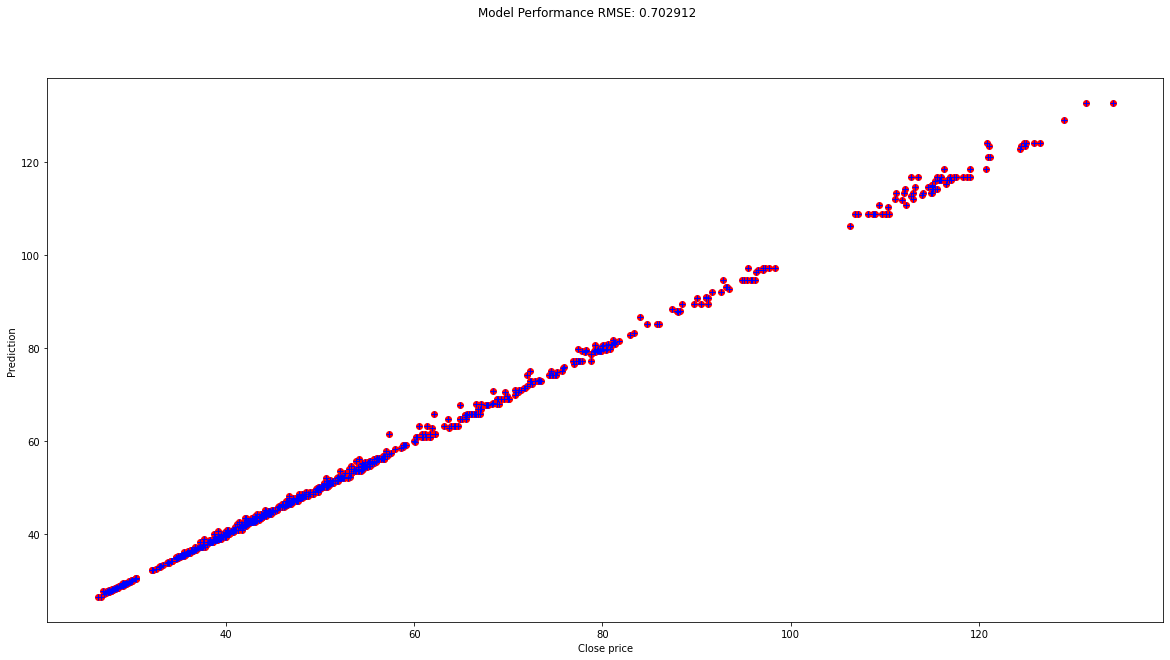

0.7029119394610003


In [71]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(dataset)

rfResult = rfPred.toPandas()

plt.figure(figsize=(20,10))
plt.plot(rfResult.label, rfResult.prediction, 'b+')
plt.scatter(rfResult.label, rfResult.prediction, color="red")
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [44]:
dataset.printSchema()

root
 |-- label: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- unadjustedVolume: double (nullable = true)
 |-- change: double (nullable = true)
 |-- changePercent: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- changeOverTime: double (nullable = true)



In [51]:
#number of entries in dataset
dataset.count()

1038

In [49]:
df2 = dataset.distinct()

In [50]:
#number of distinct entries in dataset
df2.count()

1038

In [63]:
dfna = dataset.na.drop()

In [65]:
#number of not null entries
dfna.count()

1038